In [16]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
common	     datautils	  Index.ipynb  output			 README.md
config.yaml  experiments  index.py     preprocess_imagenette.py  requirements.txt
data	     Index_bc.py  models       project-structure.md	 run.yaml


In [17]:
# move into project directory
repo_name = "Image-Colorization"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/Image-Colorization
common	     datautils	  Index.ipynb  output			 README.md
config.yaml  experiments  index.py     preprocess_imagenette.py  requirements.txt
data	     Index_bc.py  models       project-structure.md	 run.yaml


In [18]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

In [19]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
#!tar -xvzf data/imagenette2-320.tgz
#!unzip -qq data/imagenette2-320-processed.zip -d data/


In [20]:
# setup some imports
#custom imports
from common.transforms import ToTensor
from datautils.datareader import DataReader
from datautils.datareader import ImagenetteReader
from datautils.dataset import CustomDataset
from datautils.dataset import CustomImagenetDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_saved_model, get_modelinfo, get_model_data
from models.unet import UNet
from models.conv_net import ConvNet
from models.custom_models import get_model

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from experiments.experiments import Experiment
from common.visualization import Visualization
from experiments.test_model import ModelTester

In [21]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'L', 'data_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization', 'use_gpu': True, 'y_key': 'AB'}


In [22]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': True, 'batch_size': 32, 'val_split_method': 'fixed-split', 'k': 3, 'val_percentage': 20, 'loss': 'l1', 'epoch_interval': 10, 'num_epochs': 1000}, 'model': {'name': 'conv_net', 'optimizer': 'Adam', 'lr': 0.0001, 'weight_decay': 1e-07, 'amsgrad': True, 'momentum': 0.8}, 'dataset': {'name': 'imagenette', 'size': 'subset'}, 'test_model': False}


In [23]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [24]:
# read and load custom data

#save X_key and y_key
save2config('X_key', 'L')
save2config('y_key', 'AB')

if exp_params['dataset']['name'] == 'custom':
    #preprocess data or load preprocessed data (custom)
    dr = DataReader()
    ds = dr.get_split_data()
    Ltr, ABtr, ftr_len = ds['Ltr'], ds['ABtr'], ds['ftr_len']
    Lte, ABte, te_len = ds['Lte'], ds['ABte'], ds['te_len']
    print('Shape of X and y:', ds['Ltr'].shape, ds['ABtr'].shape)

    #transform data
    composed_transforms =  transforms.Compose([
        ToTensor()
    ])
    #convert to dataset
    ftr_dataset = CustomDataset(Ltr, ABtr, ftr_len)
    te_dataset = CustomDataset(Lte, ABte, te_len)
    smlen = int(0.01 * len(ftr_dataset))
    smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
    smftrte_dataset = torch.utils.data.Subset(ftr_dataset, list(range(10)))
    smtelen = int(0.1 * len(te_dataset))
    smfte_dataset = torch.utils.data.Subset(te_dataset, list(range(smtelen)))
    print('Full train dataset length:', len(ftr_dataset))
    print('Test dataset length:', len(te_dataset))
    print('Subset train dataset length:', smlen)
    print('Subset test dataset length:', smtelen, '\n')
elif exp_params['dataset']['name'] == 'imagenette':
    dr = ImagenetteReader()
    train_paths, test_paths = dr.get_data_filepaths()
    ftr_dataset = CustomImagenetDataset(train_paths)
    te_dataset = CustomImagenetDataset(test_paths)
    smlen = int(0.01 * len(ftr_dataset))
    smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
    smtelen = int(0.01 * len(te_dataset))
    smfte_dataset = torch.utils.data.Subset(te_dataset, list(range(smtelen)))
    smftrte_dataset = torch.utils.data.Subset(smftr_dataset, list(range(10)))
    print('Full train dataset length:', len(ftr_dataset))
    print('Test dataset length:', len(te_dataset))
    print('Subset train dataset length:', smlen)
    print('Subset test dataset length:', smtelen, '\n')
else:
    raise SystemError('Invalid dataset name passed!')



Full train dataset length: 9469
Test dataset length: 3925
Subset train dataset length: 94
Subset test dataset length: 39 



In [25]:
# model training

if exp_params['dataset']['name'] == 'custom':
    if exp_params['dataset']['size'] == 'subset':
        #model training with small dataset (custom)
        exp = Experiment(exp_params["model"]["name"], smftr_dataset)
        model_history = exp.train()
    else:
        #model training with full dataset (custom)
        exp = Experiment(exp_params["model"]["name"], ftr_dataset)
        model_history = exp.train()
elif exp_params['dataset']['name'] == 'imagenette':
    if exp_params['dataset']['size'] == 'subset':
        #model training with small dataset (imagenette)
        composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])
        exp = Experiment(exp_params["model"]["name"], smftr_dataset, composed_transforms, 'imagenette')
        model_history = exp.train()
    else:
        #model training with full dataset (imagenette)
        composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])
        exp = Experiment(exp_params["model"]["name"], ftr_dataset, composed_transforms, 'imagenette')
        model_history = exp.train()
else:
    raise SystemError('Invalid dataset name passed!')

Running straight split
Loading saved model
	Running Epoch 240


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


	Epoch 240 Training Loss: 0.08001531111566644
	Epoch 240 Validation Loss: 0.08404024690389633
	Running Epoch 250


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


	Epoch 250 Training Loss: 0.07781849017268733
	Epoch 250 Validation Loss: 0.0819392278790474
	Running Epoch 260


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


	Epoch 260 Training Loss: 0.07751158977809705
	Epoch 260 Validation Loss: 0.0826038047671318
	Running Epoch 270


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


	Epoch 270 Training Loss: 0.07566076791600178
	Epoch 270 Validation Loss: 0.07832422852516174
	Running Epoch 280


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


	Epoch 280 Training Loss: 0.07560399919748306
	Epoch 280 Validation Loss: 0.08401956409215927
	Running Epoch 290


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


	Epoch 290 Training Loss: 0.07361784930291929
	Epoch 290 Validation Loss: 0.07875771820545197
	Running Epoch 300


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


	Epoch 300 Training Loss: 0.07056116038247158
	Epoch 300 Validation Loss: 0.0762743130326271
	Running Epoch 310


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


	Epoch 310 Training Loss: 0.07098452825295298
	Epoch 310 Validation Loss: 0.09016787260770798
	Running Epoch 320


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 320 Training Loss: 0.06865628181319487
	Epoch 320 Validation Loss: 0.08039865642786026
	Running Epoch 330


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


	Epoch 330 Training Loss: 0.0670441440061519
	Epoch 330 Validation Loss: 0.08348360657691956
	Running Epoch 340


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


	Epoch 340 Training Loss: 0.06530017954738516
	Epoch 340 Validation Loss: 0.08217557519674301
	Running Epoch 350


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


	Epoch 350 Training Loss: 0.06649534149389517
	Epoch 350 Validation Loss: 0.08745000511407852
	Running Epoch 360


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


	Epoch 360 Training Loss: 0.06397188023517006
	Epoch 360 Validation Loss: 0.07972333580255508
	Running Epoch 370


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


	Epoch 370 Training Loss: 0.059083278634046256
	Epoch 370 Validation Loss: 0.08256980031728745
	Running Epoch 380


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


	Epoch 380 Training Loss: 0.06088077629867353
	Epoch 380 Validation Loss: 0.08119455724954605
	Running Epoch 390


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


	Epoch 390 Training Loss: 0.05980434053038296
	Epoch 390 Validation Loss: 0.07785509526729584
	Running Epoch 400


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


	Epoch 400 Training Loss: 0.0555327232731016
	Epoch 400 Validation Loss: 0.09598076343536377
	Running Epoch 410


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


	Epoch 410 Training Loss: 0.056827800250367114
	Epoch 410 Validation Loss: 0.08687562495470047
	Running Epoch 420


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


	Epoch 420 Training Loss: 0.05289088856232794
	Epoch 420 Validation Loss: 0.07988887280225754
	Running Epoch 430


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


	Epoch 430 Training Loss: 0.053925524024586925
	Epoch 430 Validation Loss: 0.10576216131448746
	Running Epoch 440


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 440 Training Loss: 0.051353588700294495
	Epoch 440 Validation Loss: 0.0781719908118248
	Running Epoch 450


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


	Epoch 450 Training Loss: 0.0513516911550572
	Epoch 450 Validation Loss: 0.07861444354057312
	Running Epoch 460


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


	Epoch 460 Training Loss: 0.05035341217329627
	Epoch 460 Validation Loss: 0.085842065513134
	Running Epoch 470


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


	Epoch 470 Training Loss: 0.04841692510404085
	Epoch 470 Validation Loss: 0.07971291244029999
	Running Epoch 480


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


	Epoch 480 Training Loss: 0.0501530699824032
	Epoch 480 Validation Loss: 0.0814184695482254
	Running Epoch 490


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


	Epoch 490 Training Loss: 0.05105504628859068
	Epoch 490 Validation Loss: 0.08620702475309372
	Running Epoch 500


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


	Epoch 500 Training Loss: 0.048102625106510366
	Epoch 500 Validation Loss: 0.08224234730005264
	Running Epoch 510


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


	Epoch 510 Training Loss: 0.0474985849700476
	Epoch 510 Validation Loss: 0.08159390091896057
	Running Epoch 520


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


	Epoch 520 Training Loss: 0.04246111488655994
	Epoch 520 Validation Loss: 0.0801384449005127
	Running Epoch 530


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


	Epoch 530 Training Loss: 0.041237602696606986
	Epoch 530 Validation Loss: 0.09140727669000626
	Running Epoch 540


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


	Epoch 540 Training Loss: 0.04203436308001217
	Epoch 540 Validation Loss: 0.08710389584302902
	Running Epoch 550


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


	Epoch 550 Training Loss: 0.04052582167481121
	Epoch 550 Validation Loss: 0.09745673090219498
	Running Epoch 560


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


	Epoch 560 Training Loss: 0.040926144311302586
	Epoch 560 Validation Loss: 0.07919279485940933
	Running Epoch 570


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


	Epoch 570 Training Loss: 0.04418771400263435
	Epoch 570 Validation Loss: 0.09192835539579391
	Running Epoch 580


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


	Epoch 580 Training Loss: 0.03961270949558208
	Epoch 580 Validation Loss: 0.08968701213598251
	Running Epoch 590


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


	Epoch 590 Training Loss: 0.043239351950193704
	Epoch 590 Validation Loss: 0.10001124441623688
	Running Epoch 600


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


	Epoch 600 Training Loss: 0.03908435431750197
	Epoch 600 Validation Loss: 0.096161849796772
	Running Epoch 610


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 610 Training Loss: 0.03965069686895922
	Epoch 610 Validation Loss: 0.07994589954614639
	Running Epoch 620


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


	Epoch 620 Training Loss: 0.04085112990517365
	Epoch 620 Validation Loss: 0.08361760526895523
	Running Epoch 630


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 630 Training Loss: 0.03556546921792783
	Epoch 630 Validation Loss: 0.07897984981536865
	Running Epoch 640


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


	Epoch 640 Training Loss: 0.03487223974968258
	Epoch 640 Validation Loss: 0.0832572653889656
	Running Epoch 650


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 650 Training Loss: 0.03541112161780659
	Epoch 650 Validation Loss: 0.0950017124414444
	Running Epoch 660


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


	Epoch 660 Training Loss: 0.03496081087934343
	Epoch 660 Validation Loss: 0.08723989874124527
	Running Epoch 670


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


	Epoch 670 Training Loss: 0.03521048434470829
	Epoch 670 Validation Loss: 0.08522842824459076
	Running Epoch 680


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 680 Training Loss: 0.034124990631090965
	Epoch 680 Validation Loss: 0.08360271900892258
	Running Epoch 690


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 690 Training Loss: 0.03424964609899019
	Epoch 690 Validation Loss: 0.0857314020395279
	Running Epoch 700


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


	Epoch 700 Training Loss: 0.03534722524253946
	Epoch 700 Validation Loss: 0.09002114832401276
	Running Epoch 710


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


	Epoch 710 Training Loss: 0.03709487656229421
	Epoch 710 Validation Loss: 0.084078349173069
	Running Epoch 720


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


	Epoch 720 Training Loss: 0.03431617664663415
	Epoch 720 Validation Loss: 0.11050944030284882
	Running Epoch 730


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


	Epoch 730 Training Loss: 0.03387960997459136
	Epoch 730 Validation Loss: 0.08903127908706665
	Running Epoch 740


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


	Epoch 740 Training Loss: 0.036751644783898405
	Epoch 740 Validation Loss: 0.09154228866100311
	Running Epoch 750


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


	Epoch 750 Training Loss: 0.03258770419970939
	Epoch 750 Validation Loss: 0.08547118306159973
	Running Epoch 760


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 760 Training Loss: 0.031030007294918362
	Epoch 760 Validation Loss: 0.09042053669691086
	Running Epoch 770


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


	Epoch 770 Training Loss: 0.03224350610061696
	Epoch 770 Validation Loss: 0.08415795117616653
	Running Epoch 780


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 780 Training Loss: 0.029352766118551556
	Epoch 780 Validation Loss: 0.08130943775177002
	Running Epoch 790


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


	Epoch 790 Training Loss: 0.03355590489349867
	Epoch 790 Validation Loss: 0.10976577550172806
	Running Epoch 800


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


	Epoch 800 Training Loss: 0.029194190510009464
	Epoch 800 Validation Loss: 0.0876830443739891
	Running Epoch 810


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


	Epoch 810 Training Loss: 0.033545270562171936
	Epoch 810 Validation Loss: 0.0887872651219368
	Running Epoch 820


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 820 Training Loss: 0.030239074441947435
	Epoch 820 Validation Loss: 0.09862257540225983
	Running Epoch 830


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


	Epoch 830 Training Loss: 0.03029324428031319
	Epoch 830 Validation Loss: 0.08682410418987274
	Running Epoch 840


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


	Epoch 840 Training Loss: 0.030843734349075117
	Epoch 840 Validation Loss: 0.09003151953220367
	Running Epoch 850


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


	Epoch 850 Training Loss: 0.029297361052349993
	Epoch 850 Validation Loss: 0.08531714230775833
	Running Epoch 860


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


	Epoch 860 Training Loss: 0.031915582520397084
	Epoch 860 Validation Loss: 0.08437976986169815
	Running Epoch 870


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


	Epoch 870 Training Loss: 0.03206885527623327
	Epoch 870 Validation Loss: 0.08868498355150223
	Running Epoch 880


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 880 Training Loss: 0.030170197745687084
	Epoch 880 Validation Loss: 0.09572644531726837
	Running Epoch 890


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


	Epoch 890 Training Loss: 0.03073863312602043
	Epoch 890 Validation Loss: 0.08192785829305649
	Running Epoch 900


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


	Epoch 900 Training Loss: 0.02928044548944423
	Epoch 900 Validation Loss: 0.08398681879043579
	Running Epoch 910


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


	Epoch 910 Training Loss: 0.02862763571503915
	Epoch 910 Validation Loss: 0.09207899868488312
	Running Epoch 920


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


	Epoch 920 Training Loss: 0.029180002643873815
	Epoch 920 Validation Loss: 0.08154428750276566
	Running Epoch 930


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


	Epoch 930 Training Loss: 0.025985878549124066
	Epoch 930 Validation Loss: 0.09257526695728302
	Running Epoch 940


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


	Epoch 940 Training Loss: 0.026713212265780096
	Epoch 940 Validation Loss: 0.08424685150384903
	Running Epoch 950


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


	Epoch 950 Training Loss: 0.026262346361028522
	Epoch 950 Validation Loss: 0.0861726924777031
	Running Epoch 960


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


	Epoch 960 Training Loss: 0.028049790545513754
	Epoch 960 Validation Loss: 0.0947265774011612
	Running Epoch 970


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


	Epoch 970 Training Loss: 0.02868848215592535
	Epoch 970 Validation Loss: 0.086089588701725
	Running Epoch 980


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


	Epoch 980 Training Loss: 0.027233288084205828
	Epoch 980 Validation Loss: 0.08424784243106842
	Running Epoch 990


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


	Epoch 990 Training Loss: 0.026888494232767506
	Epoch 990 Validation Loss: 0.09433899074792862
	Running Epoch 1000


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


	Epoch 1000 Training Loss: 0.02796099119280514
	Epoch 1000 Validation Loss: 0.08812890201807022



Model validation results

Model results




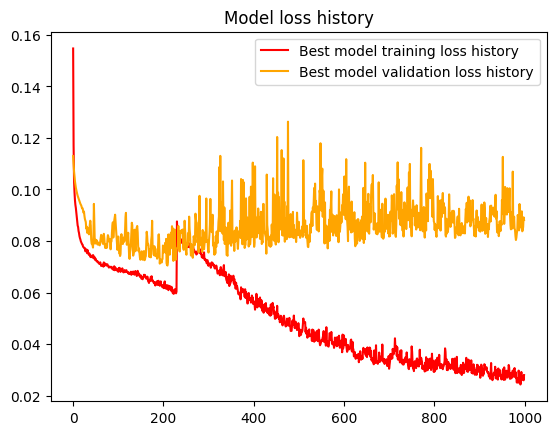


Model Training Loss: 0.02796099119280514
Model Validation Loss: 0.08812890201807022


In [26]:
# test model on validation set

if exp_params['dataset']['name'] == 'custom' or exp_params['dataset']['name'] == 'imagenette':
    # get best model with custom dataset
    model, model_history, _ = get_model_data(exp_params["model"]["name"])
    #model = get_saved_model(model, '')
    model_info = get_modelinfo('')
    print("\nModel validation results")
    #visualization results
    vis = Visualization(model_info, model_history)
    vis.get_results()
else:
    raise SystemError('Invalid dataset name passed!')



Testing Saved Model on subset of training set


<Figure size 640x480 with 0 Axes>

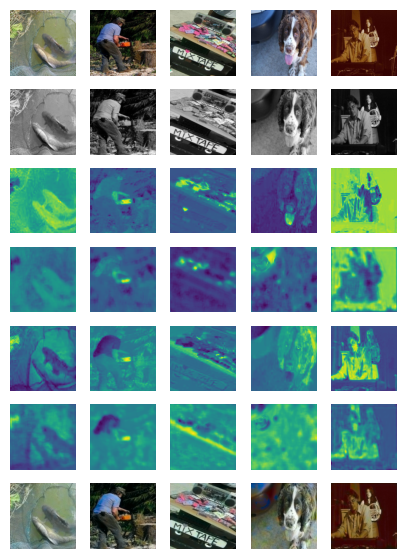


Test Loss: 0.05194885656237602
Test Accuracy: tensor(0.) 



In [27]:
# test fine-tuned model on training set

if exp_params['dataset']['name'] == 'custom':
    #model testing with small subset of training dataset
    model = get_model(exp_params["model"]["name"])
    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
    print("\n\nTesting Saved Model on Training set subset")
    mt = ModelTester(model, smftrte_dataset)
    mt.test_and_plot(ds["RGBtr"], ABtr, "best_model", True)
elif exp_params['dataset']['name'] == 'imagenette':
    #model testing with small subset of training dataset (imagenette)
    composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])
    model = get_model(exp_params["model"]["name"])
    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
    print("\n\nTesting Saved Model on subset of training set")
    mt = ModelTester(model, smftrte_dataset, composed_transforms)
    mt.test_imagenette_and_plot(True)
else:
    raise SystemError('Invalid dataset name passed!')


In [28]:
'''
# test fine-tuned model on test set
if exp_params['dataset']['name'] == 'custom':
    # model testing with small subset of training dataset
    model = get_model(exp_params["model"]["name"])
    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
    if exp_params['dataset']['size'] == 'subset':
        print("\n\nTesting Saved Model subset of test set")
        mt = ModelTester(model, smfte_dataset)
        mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)
    else:
        print("\n\nTesting Saved Model on full test set")
        mt = ModelTester(model, te_dataset)
        mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)
elif exp_params['dataset']['name'] == 'imagenette':
    # model testing with small subset of training dataset (imagenette)
    model = get_model(exp_params["model"]["name"])
    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
    if exp_params['dataset']['size'] == 'subset':
        print("\n\nTesting Saved Model on subset of test set")
        mt = ModelTester(model, smfte_dataset, composed_transforms)
        mt.test_imagenette_and_plot(True)
    else:
        print("\n\nTesting Saved Model on full test set")
        mt = ModelTester(model, te_dataset, composed_transforms)
        mt.test_imagenette_and_plot(True)
else:
    raise SystemError('Invalid dataset name passed!')
'''

'\n# test fine-tuned model on test set\nif exp_params[\'dataset\'][\'name\'] == \'custom\':\n    # model testing with small subset of training dataset\n    model = get_model(exp_params["model"]["name"])\n    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))\n    if exp_params[\'dataset\'][\'size\'] == \'subset\':\n        print("\n\nTesting Saved Model subset of test set")\n        mt = ModelTester(model, smfte_dataset)\n        mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)\n    else:\n        print("\n\nTesting Saved Model on full test set")\n        mt = ModelTester(model, te_dataset)\n        mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)\nelif exp_params[\'dataset\'][\'name\'] == \'imagenette\':\n    # model testing with small subset of training dataset (imagenette)\n    model = get_model(exp_params["model"]["name"])\n    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_loc